
![molprop](https://storage.googleapis.com/polaris-public/icons/icons8-bear-100-Molprop.png)
## Molecular representation benchmarks - MolProp250K leadlike

## Background

Molecular representations are crucial for understanding molecular structure, predicting properties, QSAR studies, toxicology and chemical modeling and other aspects in drug discovery tasks. Therefore, benchmarks for molecular representations are critical tools that drive progress in the field of computational chemistry and drug design. In recent years, many large models have been trained for learning molecular representation. The aim is to evaluate if large pretrained models are capable of predicting various “easy-to-compute” molecular properties. 


## Description of molecular properties
 The computed properties are molecular weight, fraction of sp3 carbon atoms (fsp3), number of rotatable bonds, topological polar surface area, computed logP, formal charge, number of charged atoms, refractivity and number of aromatic rings. These properties are widely used in molecule design and molecule prioritization.

## Data resource
**Reference**: https://pubs.acs.org/doi/10.1021/acs.jcim.2c01253 

**Raw data**: https://cartblanche22.docking.org 


In [5]:
import pandas as pd
import datamol as dm
import numpy as np
import polaris
from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID
import os
import pathlib

os.chdir(pathlib.Path("__file__").absolute().parents[1])

from utils import *

In [6]:
url = "gs://polaris-public/data/raw/zinc22/leadlike_random250K.txt"
data = pd.read_table(url, sep=" ")

In [7]:
data.head(5)

,tranche,zincid,SMILES
0,H23P200,ZINCnq00000kfAtM,Cc1ccc(C2(CNC(=O)[C@H]3C[C@@H](C(F)(F)F)[C@@H]...
1,H23P220,ZINCns000000ES5B,CC[C@@H]1CCCN1C(=O)C(=O)NC[C@]1(C)CCOC2(CCC2)C1
2,H25P130,ZINCpj00000e6qq6,CCC(CC)N1C[C@@H](C(=O)OCC(=O)c2nn(CC)nc2C)CC1=O
3,H24P190,ZINCop000001MPbb,CCCOC(=O)CCNC(=O)NC[C@H]1CC[C@H](C(=O)OCC)CC1
4,H24P320,ZINCoC000000N5BF,Cc1[nH]nc2c1CN(C(=O)CCCCC#Cc1ccccc1)CC2


In [8]:
mol_col = "SMILES"

In [22]:
# curate
curator = curation.MolecularCurator(
    data=data,
    data_cols=[],
    mol_col=mol_col,
    keep_all_rows=False,
)
df_curated = curator()

In [35]:
properties_fn = {
    "mw": dm.descriptors.mw,
    "fsp3": dm.descriptors.fsp3,
    "n_rotatable_bonds": dm.descriptors.n_rotatable_bonds,
    "tpsa": dm.descriptors.tpsa,
    "clogp": dm.descriptors.clogp,
    "formal_charge": dm.descriptors.formal_charge,
    "n_charged_atoms": dm.descriptors.n_charged_atoms,
    "refractivity": dm.descriptors.refractivity,
    "n_aromatic_rings": dm.descriptors.n_aromatic_rings,
}

In [37]:
# use the curated smiles columns for the consistency to the other benchmarks
smiles_col = SMILES_COL
mols = dm.utils.parallelized(
    fn=dm.to_mol, inputs_list=df_full[smiles_col], progress=True
)

  0%|          | 0/250000 [00:00<?, ?it/s]

In [38]:
results = dm.descriptors.batch_compute_many_descriptors(
    mols=mols,
    progress=True,
    n_jobs=1,
    batch_size=1000,
    properties_fn=properties_fn,
    add_properties=False,
)

  0%|          | 0/250000 [00:00<?, ?it/s]

In [39]:
results

,mw,fsp3,n_rotatable_bonds,tpsa,clogp,formal_charge,n_charged_atoms,refractivity,n_aromatic_rings
0,455.118208,0.500000,8,63.05,2.64280,0,0,107.2087,2
1,312.150764,0.533333,5,66.48,2.24840,0,0,86.0940,1
2,355.283492,0.842105,13,101.29,2.36140,0,0,100.6768,0
3,334.200491,0.588235,8,107.07,0.93547,0,0,89.3623,1
4,322.152872,0.687500,3,81.87,1.59380,0,0,79.9405,1
...,...,...,...,...,...,...,...,...,...
249995,273.128883,0.833333,5,70.23,0.60950,0,0,62.6701,0
249996,358.119654,0.277778,4,79.78,3.10314,0,0,99.2114,3
249997,324.129692,0.692308,9,87.66,-0.18200,0,0,71.5142,0
249998,369.160994,0.611111,7,81.70,2.76010,0,0,96.5075,1


array([[<Axes: title={'center': 'mw'}>, <Axes: title={'center': 'fsp3'}>,
        <Axes: title={'center': 'n_rotatable_bonds'}>],
       [<Axes: title={'center': 'tpsa'}>,
        <Axes: title={'center': 'clogp'}>,
        <Axes: title={'center': 'formal_charge'}>],
       [<Axes: title={'center': 'n_charged_atoms'}>,
        <Axes: title={'center': 'refractivity'}>,
        <Axes: title={'center': 'n_aromatic_rings'}>]], dtype=object)

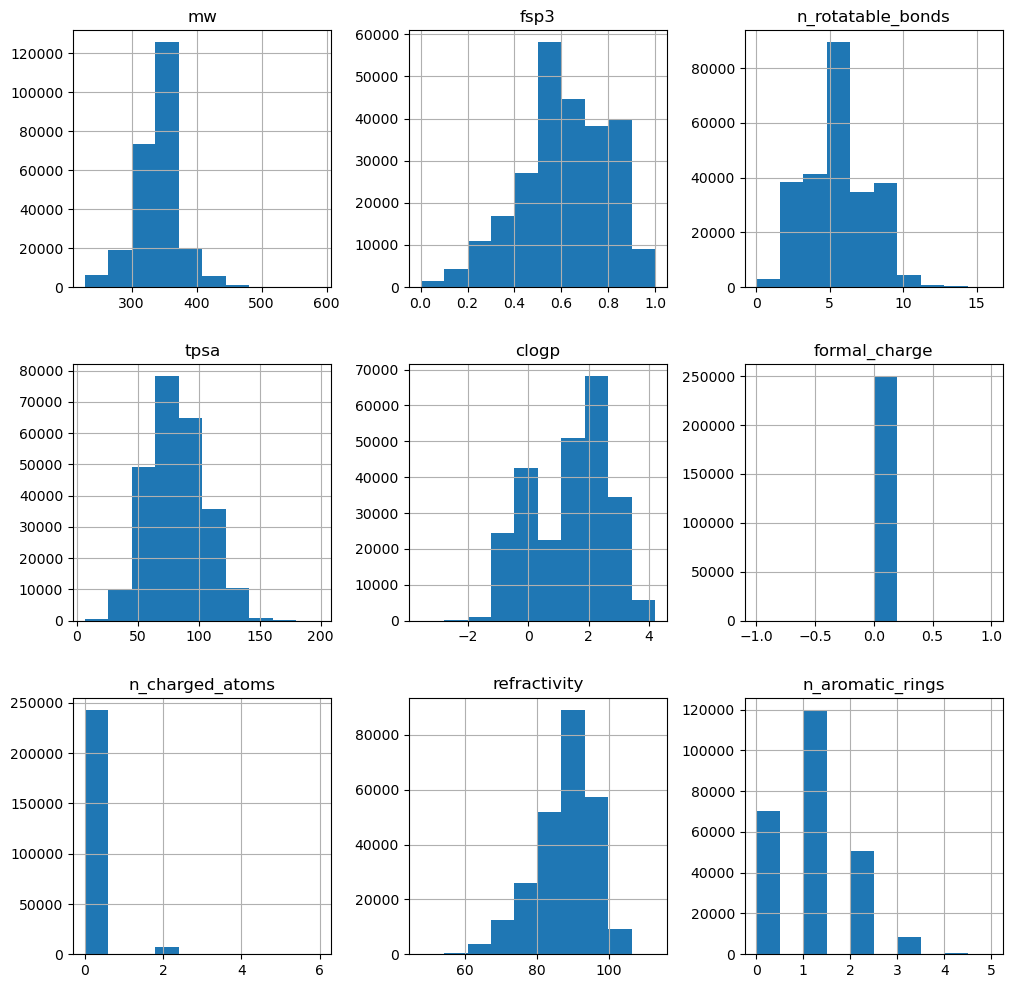

In [40]:
results.hist(figsize=(12, 12))

In [10]:
zinc250k = pd.concat([df_curated, results], axis=1)

In [11]:
zinc250k.to_parquet(
    "gs://polaris-private/sandbox/lu/dataset/zinc22-leadlike-250k/molecular_properties_{date}_full.parquet",
    index=False,
)